In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## train.csv / 出價人資料

出價人 數據集，其中包含出價人資訊清單，包括他們的ID、支付帳戶和位址。

In [3]:
train = pd.read_csv('train.csv')

train.shape

(2013, 4)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bidder_id        2013 non-null   object 
 1   payment_account  2013 non-null   object 
 2   address          2013 non-null   object 
 3   outcome          2013 non-null   float64
dtypes: float64(1), object(3)
memory usage: 63.0+ KB


- bidder_id：競標者的唯一識別碼。
- payment_account：與競標者相關聯的付款帳戶。
- address：競標者的郵寄地址。
- outcome：競標者的標籤，表示該競標者是否為機器人。值為 1.0 表示是機器人，值為 0.0 表示是人類。

In [5]:
train.duplicated().sum()

0

In [6]:
train.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


outcome
0.0    1910
1.0     103
Name: count, dtype: int64


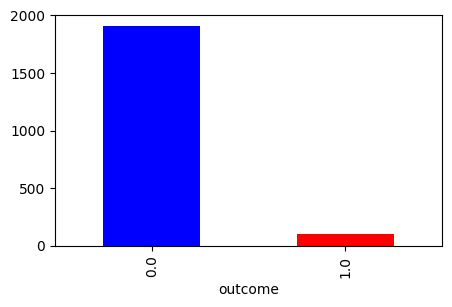

In [7]:
print(train['outcome'].value_counts())

train['outcome'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.gcf().set_size_inches(5, 3)
plt.show()

可以發現 outcome 資料不平衡，可以透過重抽樣（Resampling）來進行資料的平衡。

因為數據量 2013 筆不算大，故預計使用過採樣（Oversampling）。

實際作法採用 SMOTE（Synthetic Minority Oversampling Technique），通過生成新的合成樣本來增加少數類別數據的數量。

## test.csv / 出價人資料

In [10]:
test = pd.read_csv('test.csv')

test.shape

(4700, 3)

## bids.csv / 出價資料

出價 數據集，其中包含不同競價的 760萬 筆出價資料。

In [11]:
bids = pd.read_csv('bids.csv')

bids.shape

(7656334, 9)

In [12]:
bids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7656334 entries, 0 to 7656333
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   bid_id       int64 
 1   bidder_id    object
 2   auction      object
 3   merchandise  object
 4   device       object
 5   time         int64 
 6   country      object
 7   ip           object
 8   url          object
dtypes: int64(2), object(7)
memory usage: 525.7+ MB


- bid_id：此出價的唯一編號。
- bidder_id：競標者的唯一識別碼（與 train.csv 和 test.csv 中的 bidder_id 相同）。
- auction：拍賣活動的唯一識別碼。
- merchandise：競標者進入網站時的「初始商品類別」，不一定是他們實際出價商品的類別。
- device：訪客使用的手機型號。
- time：競標者提交出價的時間。
- country：與 IP 地址相關的國家。
- ip：競標者的 IP 地址。
- url：競標者從哪個網址引導進入的拍賣網站。

In [13]:
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [14]:
bids.duplicated().sum()

0

### 處理缺失值

In [15]:
bids.isna().sum()

bid_id            0
bidder_id         0
auction           0
merchandise       0
device            0
time              0
country        8859
ip                0
url               0
dtype: int64

In [16]:
# 缺失值的比例
bids.isna().sum() / len(bids) # 約 0.12%

bid_id         0.000000
bidder_id      0.000000
auction        0.000000
merchandise    0.000000
device         0.000000
time           0.000000
country        0.001157
ip             0.000000
url            0.000000
dtype: float64

查看缺失值比例後，因為佔總數約 0.12% 資料而已，其實可以考慮直接清掉！

In [17]:
# print(bids.shape) # (7656334, 9)

# bids.dropna(inplace=True)

# print(bids.shape) # (7656334 - 8859 = 7647475, 9)

或我們來思考要用什麼補值的方式！
> e.g. 平均數(mean)、中位數(median)、眾數(mode)

In [18]:
# 秀出那些有遺失值的列
bids[bids.isnull().values==True]

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
1647,1647,dbd340def489066ae13ffa5cd68e6d2917li7,38v0a,jewelry,phone408,9759252578947368,NaN,115.235.196.83,50rtdzaq69sxgi8
1845,1845,dbd340def489066ae13ffa5cd68e6d2917li7,7msk4,jewelry,phone45,9759253684210526,NaN,161.65.211.149,3w7pkfdhqvduki1
1968,1968,ceb6c86354e97d4d849ef5b1364bb0964nxe3,jefix,sporting goods,phone150,9759254210526315,NaN,117.34.233.29,1a1l994pff8hwc4
1982,1982,dbd340def489066ae13ffa5cd68e6d2917li7,uo3lj,jewelry,phone408,9759254315789473,NaN,115.235.196.83,g0k9f3jstsx5pud
2911,2911,cdf76f38b6f46a3bd396a99123d26909xq5c3,jefix,mobile,phone150,9759259526315789,NaN,44.203.207.204,cdr9pz0wkzokbp8
...,...,...,...,...,...,...,...,...,...
7650495,7650495,06a58d4af0fe7ee15324b0e921e8de1260vef,jqx39,mobile,phone125,9709196473684210,NaN,102.141.77.207,xj4r8a6nnv6o9ns
7650591,7650591,626159dd6f2228ede002d9f9340f75b7puk8d,x36iy,jewelry,phone35,9709196947368421,NaN,231.36.69.124,hx1meiyqlpmc77u
7650748,7650748,626159dd6f2228ede002d9f9340f75b7puk8d,obbny,jewelry,phone46,9709197631578947,NaN,11.123.113.3,v5cuis08b67aqfx
7653822,7653822,2a9dcf343aa74fd5a27cc00e04376cd5xlsra,jqx39,jewelry,phone125,9709211052631578,NaN,26.30.167.167,wmznp5194pj56ya


In [19]:
bids['country'].value_counts()

country
in    1788731
ng     586586
id     453611
tr     319574
us     318103
       ...   
an          2
er          2
gp          2
mh          1
tc          1
Name: count, Length: 199, dtype: int64

In [20]:
bids['country'].mode(), bids['country'].mode()[0]

(0    in
 Name: country, dtype: object,
 'in')

In [21]:
# 檢查變數的分布情況。
# 如果某個類別明顯佔據大多數，用 mode (眾數) 來填補缺失值是合理且常用的方法。

bids['country'] = bids['country'].fillna(bids['country'].mode()[0])

bids['country'].isna().sum()


0

In [22]:
bids.iloc[1647] # 原本有缺失值的列，已補值

bid_id                                          1647
bidder_id      dbd340def489066ae13ffa5cd68e6d2917li7
auction                                        38v0a
merchandise                                  jewelry
device                                      phone408
time                                9759252578947368
country                                           in
ip                                    115.235.196.83
url                                  50rtdzaq69sxgi8
Name: 1647, dtype: object

## 資料合併
使用 bidder_id 作為 key 將 train.csv 和 bids.csv 合併

In [23]:
bidder_unique = bids.groupby('bidder_id').nunique().reset_index()
bidder_unique

,bidder_id,bid_id,auction,merchandise,device,time,country,ip,url
0,001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,1
1,002d229ffb247009810828f648afc2ef593rb,2,1,1,2,2,1,1,1
2,0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1,1
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,3,1,3,3,1,3,2
4,00486a11dff552c4bd7696265724ff81yeo9v,20,13,1,8,20,1,10,7
...,...,...,...,...,...,...,...,...,...
6609,ffbc0fdfbf19a8a9116b68714138f2902cc13,25075,637,1,792,23487,102,18726,8039
6610,ffc4e2dd2cc08249f299cab46ecbfacfobmr3,22,15,1,13,22,6,18,12
6611,ffd29eb307a4c54610dd2d3d212bf3bagmmpl,1,1,1,1,1,1,1,1
6612,ffd62646d600b759a985d45918bd6f0431vmz,664,55,1,96,664,1,37,144


In [24]:
train_bidder_unique = train.merge(bidder_unique, on='bidder_id', how='left')
train_bidder_unique.rename(
  columns={
    'bid_id': 'bid_count',
    'auction': 'auction_count', 
    'merchandise': 'merchandise_count', 
    'device': 'device_count', 
    'time': 'time_count', 
    'country': 'country_count', 
    'ip': 'ip_count', 
    'url': 'url_count'
  }, 
  inplace=True
)

train_bidder_unique

,bidder_id,payment_account,address,outcome,bid_count,auction_count,merchandise_count,device_count,time_count,country_count,ip_count,url_count
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,24.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,3.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,155.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2008,369515b3af4f8ca582f90271d30b14b6r52aw,a1f85275793c4a782f0a668711f41b927ivc9,e6882cf204a9482edd042b6e31791dfctxzx8,0.0,36.0,25.0,1.0,4.0,33.0,4.0,5.0,2.0
2009,f939c17ffc7c39ac9b35b69e5e75179fv9pe2,a3d2de7675556553a5f08e4c88d2c2286s1m2,b9b03d5a127eb07aeb9163cdcf524e1344ac9,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2010,c806dbb2decba0ed3c4ff5e2e60a74c2wjvbl,a3d2de7675556553a5f08e4c88d2c22856leq,d02c2b288b8aabd79ff47118aff41a2dqwzwc,0.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0
2011,0381a69b7a061e9ace2798fd48f1f537mgq57,fd87037ce0304077079c749f420f0b4c54uo0,f030a221726fbcdfc4dc7dfd1b381a112hieq,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [25]:
train_bidder_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bidder_id          2013 non-null   object 
 1   payment_account    2013 non-null   object 
 2   address            2013 non-null   object 
 3   outcome            2013 non-null   float64
 4   bid_count          1984 non-null   float64
 5   auction_count      1984 non-null   float64
 6   merchandise_count  1984 non-null   float64
 7   device_count       1984 non-null   float64
 8   time_count         1984 non-null   float64
 9   country_count      1984 non-null   float64
 10  ip_count           1984 non-null   float64
 11  url_count          1984 non-null   float64
dtypes: float64(9), object(3)
memory usage: 188.8+ KB


In [42]:
# 找出有 nan 的行數
train_bidder_unique[train_bidder_unique.isnull().any(axis=1)]

,bidder_id,payment_account,address,outcome,bid_count,auction_count,merchandise_count,device_count,time_count,country_count,ip_count,url_count
49,5f50c6187a179e2ee7ba2fbcfc845c7a1smgr,7326f0a1592b18cb1e6ed7c8ebbd03a72qf7p,a3d2de7675556553a5f08e4c88d2c228uaoqg,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,02bde521e763e4f4e590e8368149e04a96il9,a3d2de7675556553a5f08e4c88d2c2286r1lb,935d2083173e96f099816c1b1f7ee249kk8zo,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,dd661e2d6e79a5b3e66c82373d50f3ee86k85,e805bf9d2399ddc37a194e04703a333c7bv82,2c2b8b44b1615ef6d632fb115a85794djmktr,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,908ce7060337fd8550760a100921f6f7wsemn,a3d2de7675556553a5f08e4c88d2c2282yldz,39b2bdec29461f8a0ae2a5a5b01d259fik8r7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,b64c209b3d1d91a663d134961af89125u0s9a,f7558102989f5665bbbea00358f8434adf9o9,5c9de1da50cc32a29ffd596ae24cd2be24cly,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,96b1df591dbbf3a002578574671d9ff1rmzev,a3d2de7675556553a5f08e4c88d2c2288tx3v,1a1d480ca96a50e5fa8af28cf9121d80gx8g2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,d2138bce99f535c244dab68652ccfa2enshxk,72a51aa2faf94e7ffdf736fdb389d4efpyojt,458d233d676d8f62406213ab319b8334dbdxh,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,c08e5e3325e2f4fea171f24ca018e675we8kj,efd15ad70741e38f212ac919ca569615r3g33,81d6c498369ab4af3fea529406dc7d96flle8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,187636e527504df29bf42d4a2b7767e54bgv7,a3d2de7675556553a5f08e4c88d2c2281swzb,a3d2de7675556553a5f08e4c88d2c2281rrln,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,74f153bd134afc92866a6bc5cceb2088120y0,a3d2de7675556553a5f08e4c88d2c228fd0s8,796f3dd849480319c21677833dc1a6c87c6p1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
train_bidder_unique.dropna(inplace=True)

## 資料集切分 train / validation

In [64]:
X = train_bidder_unique.drop([
  'bidder_id',
  'payment_account',
  'address',
  'outcome'
], axis=1)

Y = train_bidder_unique['outcome']

In [65]:
Y.value_counts()

outcome
0.0    1881
1.0     103
Name: count, dtype: int64

In [71]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1587, 8), (397, 8), (1587,), (397,))

## 模型指標、性能

In [174]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

def evaluate_model(y_test, y_pred, class_labels=["Class 0", "Class 1"]):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(3, 3))
    disp.plot(cmap="binary", ax=ax)
    plt.ylabel('Outcome')
    plt.xlabel('Predicted Outcome')
    plt.show()
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    
    return precision, recall, f1

## LR

In [163]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(x_train, y_train)
log_reg

LogisticRegression(max_iter=1000)

In [164]:
log_reg.score(x_train, y_train), log_reg.score(x_test, y_test)

(0.9483301827347196, 0.9445843828715366)

tn: 374, fp: 0, fn: 22, tp: 1


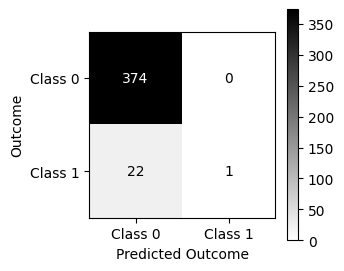

Precision: 1.0
Recall: 0.043478260869565216
F1-Score: 0.08333333333333333


(1.0, 0.043478260869565216, 0.08333333333333333)

In [173]:
evaluate_model(y_test, log_reg.predict(x_test))

In [166]:
from sklearn.linear_model import LogisticRegression

log_reg_cw = LogisticRegression(class_weight="balanced", max_iter=1000)

log_reg_cw.fit(x_train, y_train)
log_reg_cw

LogisticRegression(class_weight='balanced', max_iter=1000)

In [167]:
log_reg_cw.score(x_train, y_train), log_reg_cw.score(x_test, y_test)

(0.8147448015122873, 0.836272040302267)

tn: 321, fp: 53, fn: 12, tp: 11


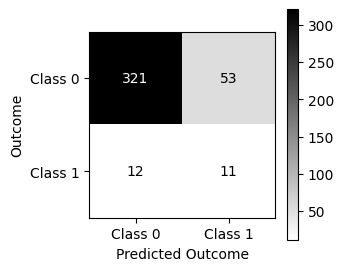

Precision: 0.171875
Recall: 0.4782608695652174
F1-Score: 0.25287356321839083


(0.171875, 0.4782608695652174, 0.25287356321839083)

In [171]:
evaluate_model(y_test, log_reg_cw.predict(x_test))

In [180]:
# SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

x_train_smote.shape, y_train_smote.shape

((3014, 8), (3014,))

In [184]:
y_train_smote.value_counts()

outcome
0.0    1507
1.0    1507
Name: count, dtype: int64

In [187]:
log_reg_smote = LogisticRegression(max_iter=1000)

log_reg_smote.fit(x_train_smote, y_train_smote)

log_reg_smote.score(x_train_smote, y_train_smote), log_reg_smote.score(x_test, y_test)

(0.6512939615129396, 0.818639798488665)

tn: 316, fp: 58, fn: 14, tp: 9


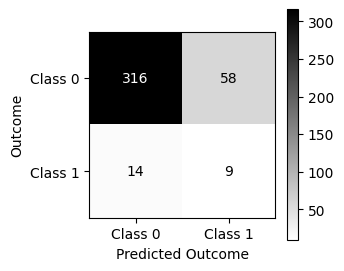

Precision: 0.13432835820895522
Recall: 0.391304347826087
F1-Score: 0.2


(0.13432835820895522, 0.391304347826087, 0.2)

In [188]:
evaluate_model(y_test, log_reg_smote.predict(x_test))